# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-mc'
epochs = 10
batch_size = 8
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(most_uncertain_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6763, Accuracy: 0.9137, F1 Micro: 0.937, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3077, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2448, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2255, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1898, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1761,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5946, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3571, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.275, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1876, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1716, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1334, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5021, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1461, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1645, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.118, Accuracy: 0.9658, F1 Micro: 0.974

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1708, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1479, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2336, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.19, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1634, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1836, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1517, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.142, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4342, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1713, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1546, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1283, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 9/10, Train Loss: 0.1136, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 10/10, Train Loss: 0.0947, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3884, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1587, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0995, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.169, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1696, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1333, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9673, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1937, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1451, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1075, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 10/10, Train Loss: 0.1001, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2033, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1649, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.149, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.1203, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0994, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1837, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1348, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 8/10, Train Loss: 0.117, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7625
Epoch 9/10, Train Loss: 0.1061, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7558
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3625, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2182, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1766, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7227
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1291, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0794, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7551
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.359, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2017, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1914, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1675, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7924
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.204, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.768
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1652, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.156, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7385
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3387, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9777, F1 Micro: 0.9831, F1 Macro: 0.8058
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7585
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3433, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1556, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3323, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9524, F1 Micro: 0.9636, F1 Macro: 0.7317
Epoch 10/10, Train Loss: 0.065, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3188, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7199
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.7397
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9628, F1 Micro: 0.9719, F1 Macro: 0.7384
Epoch 10/10, Train Loss: 0.0607, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.8042
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9747, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1889, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1679, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.8023
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.805
Epoch 10/10, Train Loss: 0.0535, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2986, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9762, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3128, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.175, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9613, F1 Micro: 0.9706, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7587
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macr

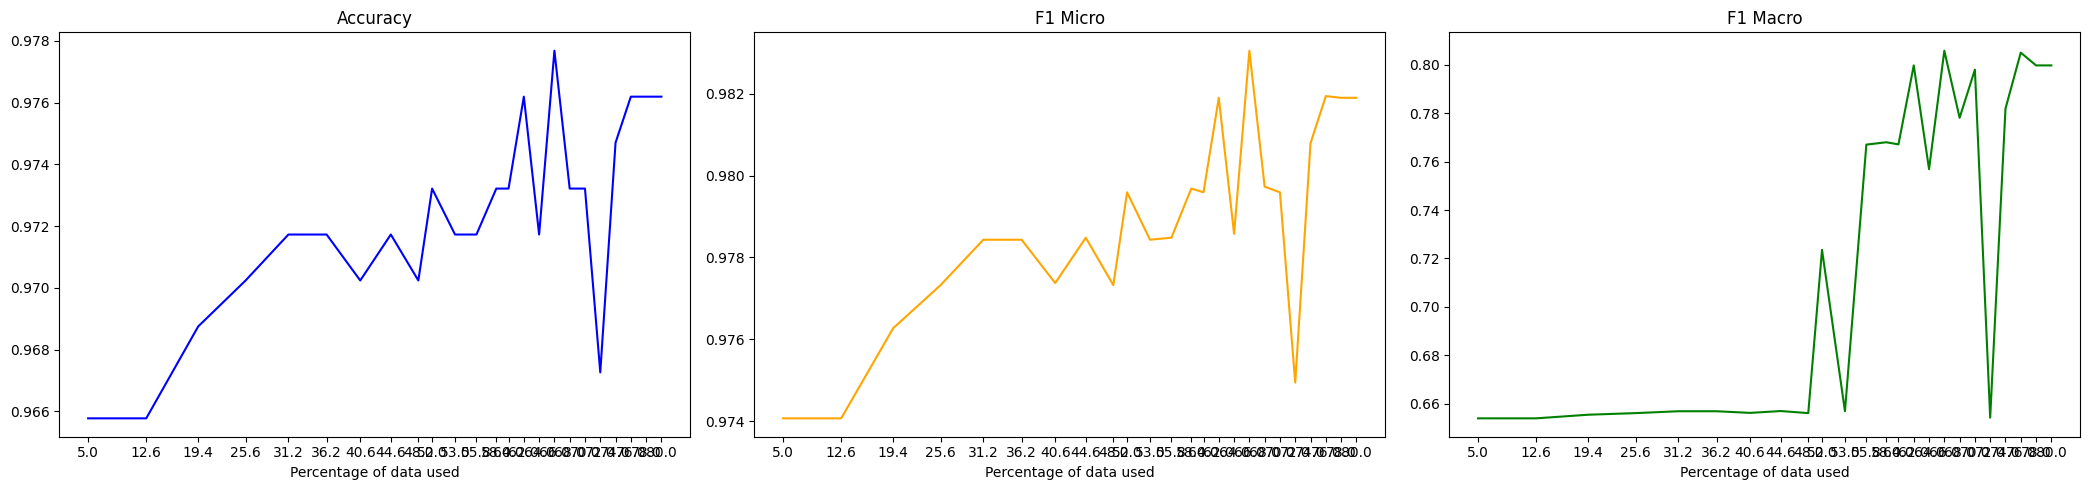

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7235, Accuracy: 0.9062, F1 Micro: 0.9317, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5261, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4066, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3144, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2468, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.256, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2063,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6291, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3105, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2414, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2435, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1923, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1685,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2079, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1431,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5036, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2005, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1872, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.182, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.1384, Accuracy: 0.9673, F1 Micro: 0.975

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2081, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1362, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.1154, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2087, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1486, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1423, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1256, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4189, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1712, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1412, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6482
Epoch 9/10, Train Loss: 0.1387, Accuracy: 0.9583, F1 Micro: 0.9676, F1 Macro: 0.648
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1885, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.165, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1387, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.6534
Epoch 8/10, Train Loss: 0.1329, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.116, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7973
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4091, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2103, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2055, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1847, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1204, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0665, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3912, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1893, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1626, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1529, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.1222, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0915, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3593, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1842, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1658, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 7/10, Train Loss: 0.1272, Accuracy: 0.9702, F1 Micro: 0.9771, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9702, F1 Micro: 0.9771, F1 Macro: 0.7957
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1945, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.756
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7963
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7544
Epoch 10/10, Train Loss: 0.0557, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3673, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1786, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.134, Accuracy: 0.9613, F1 Micro: 0.9699, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7978
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1857, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1435, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7209
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1959, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7987
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7978
Epoch 10/10, Train Loss: 0.0483, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1357, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0813, Accuracy: 0.9747, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3357, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2013, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.721
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0541, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3249, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2054, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1766, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7987
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7808
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3342, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1907, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9598, F1 Micro: 0.9688, F1 Macro: 0.7888
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7679
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.324, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1796, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9732, F1 Micro: 0.9795, F1 Macro: 0.7978
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7503
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3151, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1699, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9613, F1 Micro: 0.9701, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1314, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7987
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0434, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3278, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1924, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7236
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7809
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.7753
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.795
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9792, F1 Micro: 0.9842, F1 Macro: 0.8243
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.306, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9777, F1 Micro: 0.983, F1 Macro: 0.8005
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.8049
Epoch 10/1

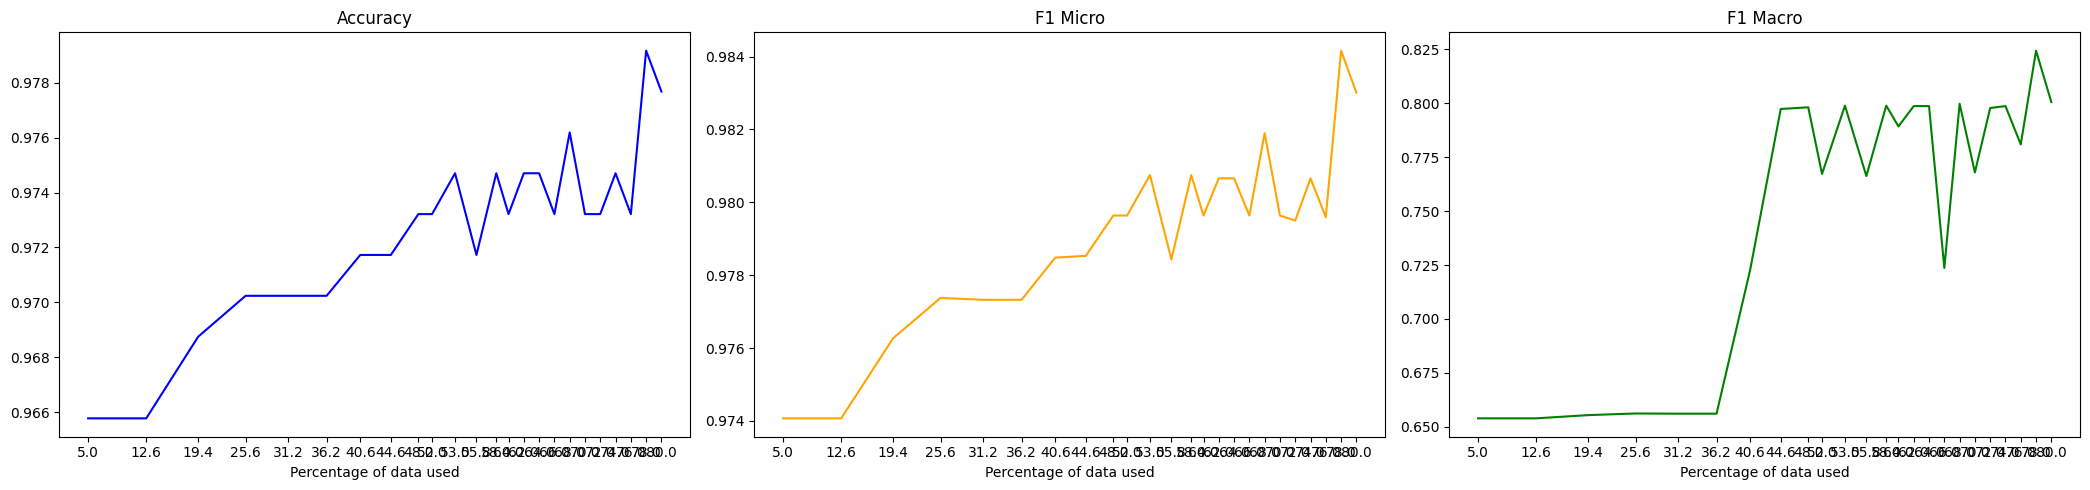

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6137, Accuracy: 0.9524, F1 Micro: 0.9635, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4556, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3444, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.248, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1986, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2051, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1674,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5454, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2863, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2253, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2387, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2001, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1538, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1608, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1695,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4751, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1937, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2153, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1433, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1558, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.1642, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.1129, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6484
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4523, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2626, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2165, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2332, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1997, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1902, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1666, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.1713, Accuracy: 0.9613, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4267, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2029, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.177, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1481, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1244, Accuracy: 0.9643, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3957, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1728, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1454, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.1216, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9613, F1 Micro: 0.9703, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1931, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1828, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1748, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.14, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Epoch 9/10, Train Loss: 0.123, Accuracy: 0.9643, F1 Micro: 0.9727, F1 Macro: 0.6541
Epoch 10/10, Train Loss: 0.0969, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1905, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1833, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1617, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1427, Accuracy: 0.9554, F1 Micro: 0.9657, F1 Macro: 0.6503
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1208, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7229
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2206, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.17, Accuracy: 0.9554, F1 Micro: 0.9654, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1585, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 8/10, Train Loss: 0.1208, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6531
Epoch 9/10, Train Loss: 0.0982, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7029
Epoch 10/10, Train Loss: 0.0914, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1886, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.198, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.1198, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1211, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3512, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1987, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1645, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1246, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7124
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9717, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3591, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2126, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7441
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7659
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Epoch 8/10, Train Loss: 0.1057, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.0882, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3436, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2037, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1806, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1454, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.6855
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9598, F1 Micro: 0.9691, F1 Macro: 0.741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7576
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1261, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7811
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2008, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1822, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1755, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9673, F1 Micro: 0.9748, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9747, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.332, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3108, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2006, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6568
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9643, F1 Micro: 0.9725, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3121, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1956, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9688, F1 Micro: 0.9759, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9688, F1 Micro: 0.976, F1 Macro: 0.8002
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3102, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9747, F1 Micro: 0.9806, F1 Macro: 0.7986
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0529, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1791, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.151, Accuracy: 0.9717, F1 Micro: 0.9783, F1 Macro: 0.6566
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.7761
Epoch 10/10, Train Loss: 0.0484, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2996, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7243
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9702, F1 Micro: 0.9771, F1 Macro: 0.7958
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2888, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9747, F1 Micro: 0.9808, F1 Macro: 0.799
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3107, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1859, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1294, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9762, F1 Micro: 0.9

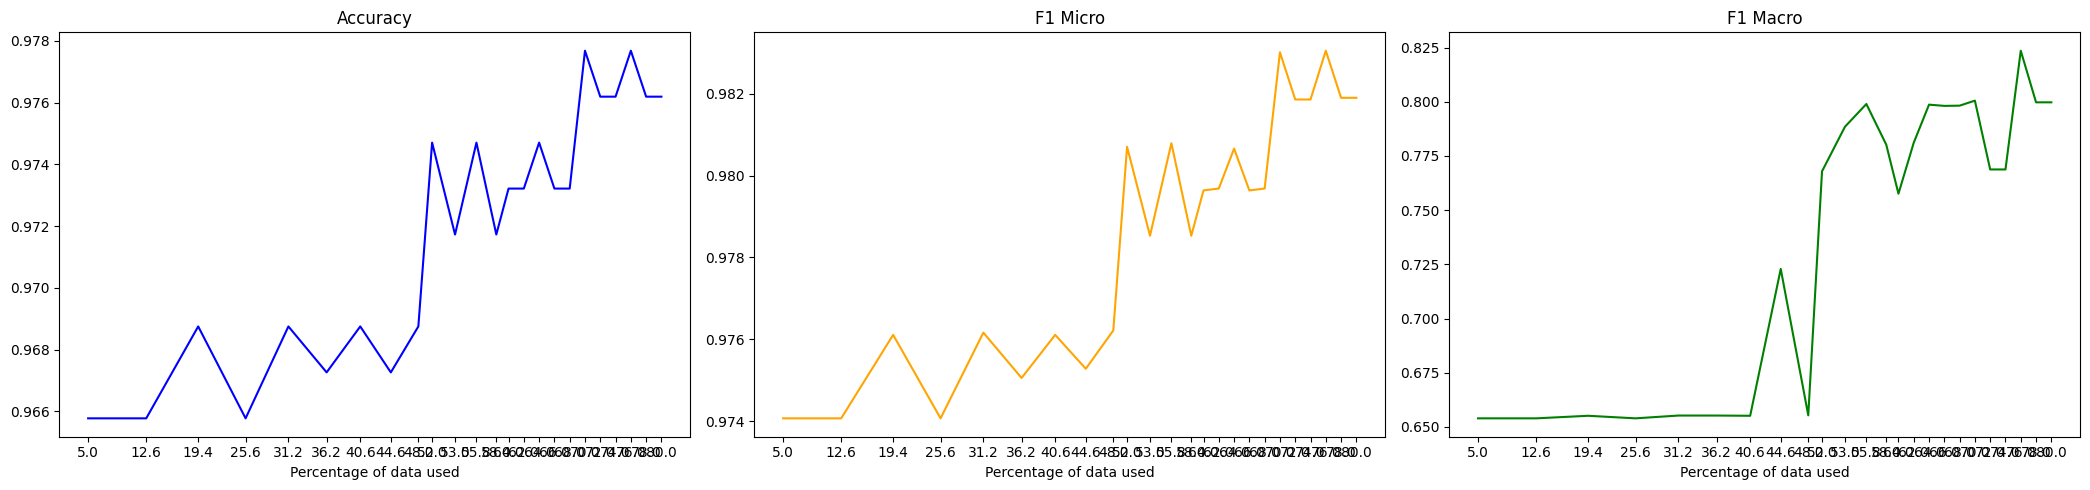

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6047, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3257, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3014, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2584, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.245, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1922, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1935, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1923, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1943, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1646, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1314, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1463,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4263, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1224, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.124, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0934, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4158, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1596, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1276, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.111, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1519, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1421, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1387, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1425,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1865, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1444, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1247, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1128,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1524, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1403, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Epoch 9/10, Train Loss: 0.1037, Accuracy: 0.9628, F1 Micro: 0.971

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1921, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1469, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1222, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1852, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1343, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1079, Accuracy: 0.9688, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3211, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1888, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1845, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1565, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1248, Accuracy: 0.9673, F1 Micro: 0.975, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0991, Accuracy: 0.9688, F1 Micro: 0.9762

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.319, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1968, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1677, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1748, Accuracy: 0.9628, F1 Micro: 0.9715, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1616, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7204
Epoch 8/10, Train Loss: 0.1339, Accuracy: 0.9628, F1 Micro: 0.9714, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1057, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3241, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1162, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7499
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.9464, F1 Micro: 0.958, F1 Macro: 0.7489
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.307, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1995, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1369, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1131, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0898

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3168, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2045, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1562, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1387, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9747, F1 Micro: 0.9809, F1 Macro: 0.8221
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7634
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2981, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1979, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1284, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0785, Accuracy: 0.9732, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3061, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1849, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1793, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1207, Accuracy: 0.9658, F1 Micro: 0.9743, F1 Macro: 0.7507
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9643, F1 Micro: 0.9724, F1 Macro: 0.792
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2996, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1421, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.8199
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2911, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9613, F1 Micro: 0.9709, F1 Macro: 0.7426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1304, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.8218
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7746
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2935, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.199, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1502, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0708

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3006, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.9568, F1 Micro: 0.9678, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9732, F1 Micro: 0.9797, F1 Macro: 0.7982
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9702, F1 Micro: 0.9772, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2665, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9732, F1 Micro: 0.9798, F1 Macro: 0.8214
Epoch 8/10, Train Loss: 0.0745, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.798
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9658, F1 Micro: 0.9738, F1 Macro: 0.7846
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2809, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7998
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7458
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.7836
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2658, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1881, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1548, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9598, F1 Micro: 0.9699, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9762, F1 Micro: 0.9819, F1 Macro: 0.7997
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9658, F1 Micro: 0.9736, F1 Macro: 0.8158
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9613, F1 Micro: 0.9707, F1 Macro: 0.7429
Epoch 10/10, Train Loss: 0.0382, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2825, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1675, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0986, Accuracy: 0.9717, F1 Micro: 0.9786, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7455
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9539, F1 Micro: 0.9648, F1 Macro: 0.7327
Epoch 10/10

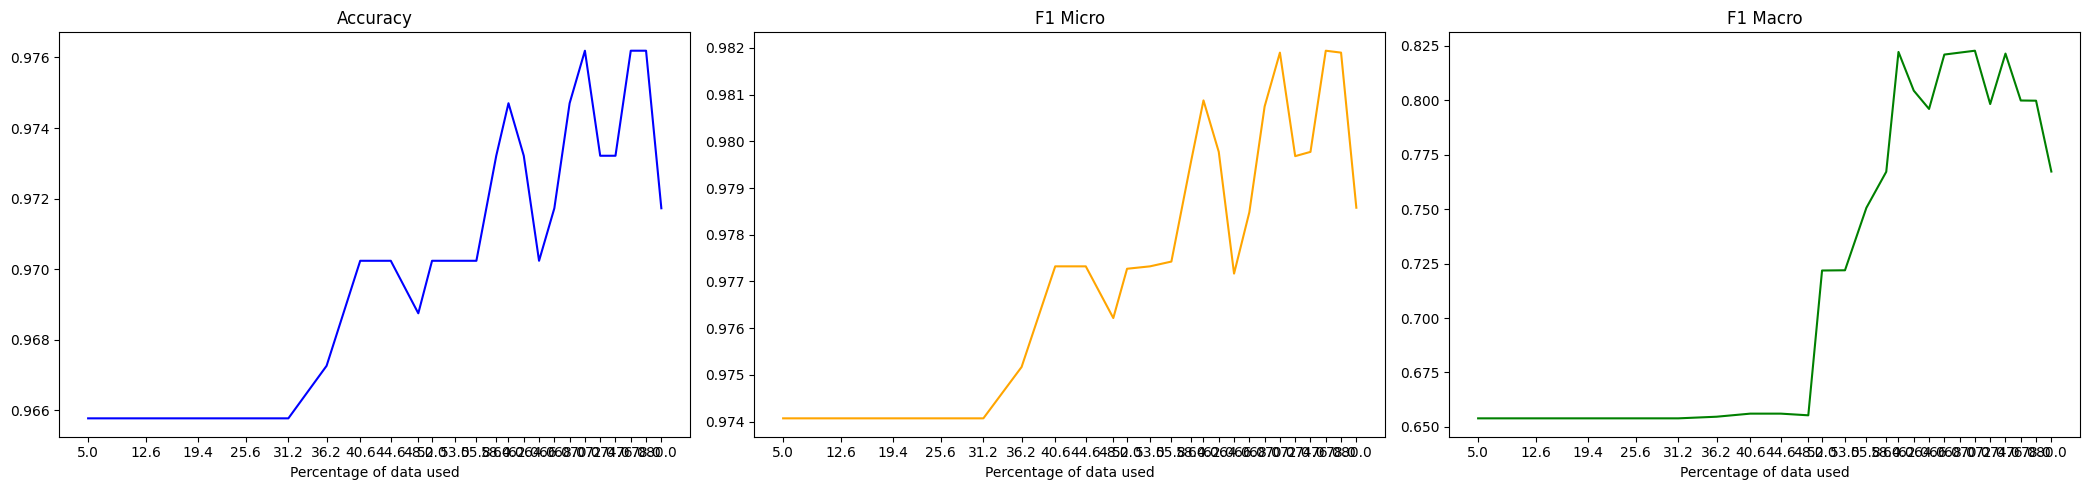

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6824, Accuracy: 0.933, F1 Micro: 0.9506, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3581, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3132, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2816, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2517, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2263, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2142, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.225, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5662, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3263, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2805, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2104, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2196, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1734, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1717, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.178, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1733, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4648, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1965, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1713, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1894, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1758, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1354,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4542, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1547, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1588, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1745,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4217, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2118, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1973, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1545, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1437, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1211,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.396, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2084, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1871, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1801, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 7/10, Train Loss: 0.1376, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.1309, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 9/10, Train Loss: 0.1233, Accuracy: 0.9643, F1 Micro: 0.9726, F1 Macro: 0.6525
Epoch 10/10, Train Loss: 0.0887, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2193, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1389, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1615, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 8/10, Train Loss: 0.1368, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1126, Accuracy: 0.9702, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.197, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1569, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1423, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3382, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1574, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1396, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9673, F1 Micro: 0.9751, F1 Macro: 0.7028
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7577
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3441, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1989, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1577, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.657
Epoch 7/10, Train Loss: 0.1424, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.9658, F1 Micro: 0.9737, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9702, F1 Micro: 0.9775, F1 Macro: 0.7479
Epoch 10/10, Train Loss: 0.0622, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1543, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0944, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7971
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3526, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1805, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1602, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.12, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9702, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3172, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1695, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9673, F1 Micro: 0.9753, F1 Macro: 0.7579
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0613, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3359, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1896, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1532, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1356, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.9702, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3213, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1951, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7559
Epoch 10/10, Train Loss: 0.0637, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3159, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1978, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.7504
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9643, F1 Micro: 0.9729, F1 Macro: 0.7376
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3073, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1996, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.9658, F1 Micro: 0.9739, F1 Macro: 0.7019
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7587
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3011, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1548, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9598, F1 Micro: 0.969, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.7551
Epoch 10/10, Train Loss: 0.0518, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3222, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1692, Accuracy: 0.9673, F1 Micro: 0.9749, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6554
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9643, F1 Micro: 0.9731, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9717, F1 Micro: 0.9784, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9643, F1 Micro: 0.973, F1 Macro: 0.7377
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2862, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1716, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1564, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1579, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1397, Accuracy: 0.9688, F1 Micro: 0.9762, F1 Macro: 0.6552
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9613, F1 Micro: 0.9702, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.7793
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9658, F1 Micro: 0.974, F1 Macro: 0.7567
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2846, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1846, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1655, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7449
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9673, F1 Micro: 0.9752, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.7989
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2928, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1867, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9702, F1 Micro: 0.9773, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9598, F1 Micro: 0.9694, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9702, F1 Micro: 0.9774, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9717, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.285, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1764, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1448, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9688, F1 Micro: 0.9764, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9717, F1 Micro: 0.9785, F1 Macro: 0.7973
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.049

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.27, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1631, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1534, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9658, F1 Micro: 0.9741, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9688, F1 Micro: 0.9763, F1 Macro: 0.6555
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9688, F1 Micro: 0.9761, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9747, F1 Micro: 0.9807, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9658, F1 Micro: 0.9742, F1 Macro: 0.7387
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9732, F1 Micro: 0.9796, F1 Macro: 0.7981
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0

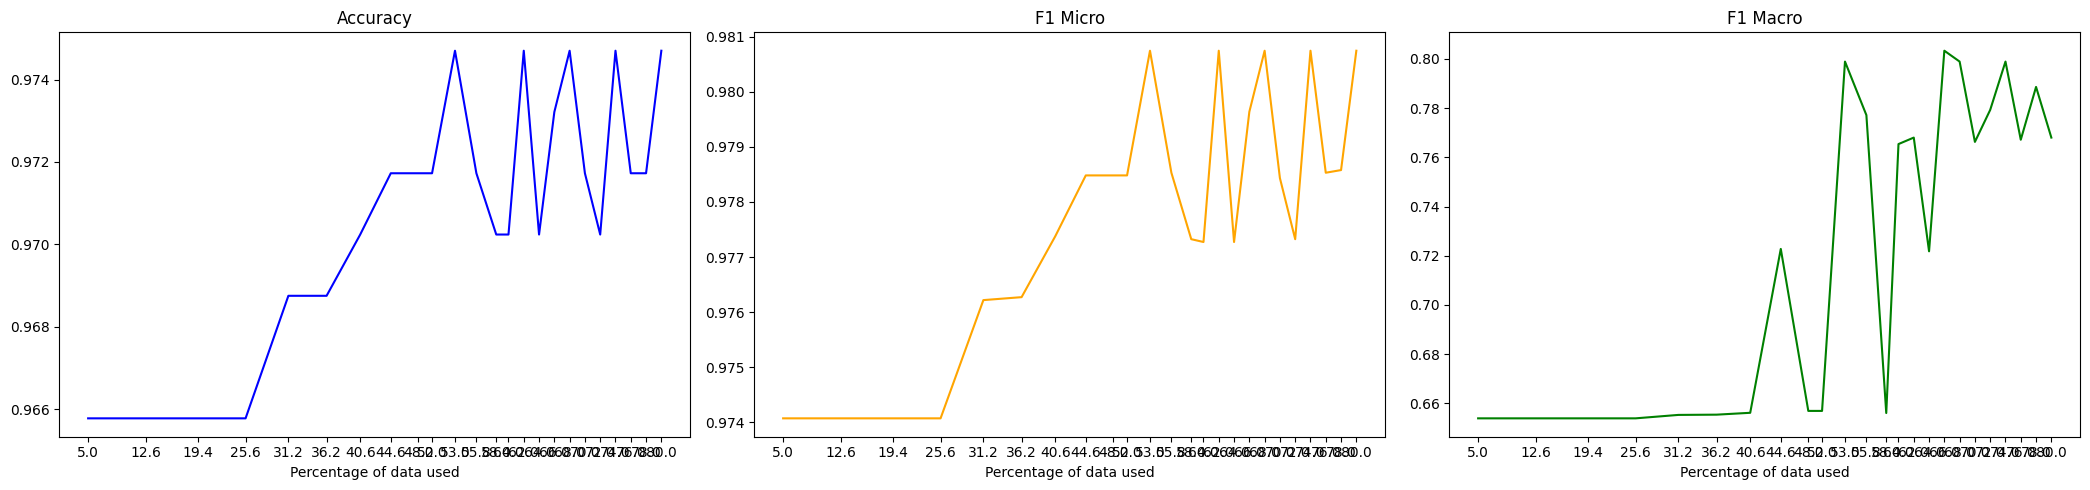

In [21]:
active_learning(seeds[4], 4)